# MAL WEBSCRAPER

This file documents the process followed in extracting and analyzing data on 10 years of anime (2014 - 2023) from MyAnimeList.com. 

### BASE FUNCTIONS

**Get_BS** - Using any webpage as an input, this function returns the BS Object of the webpage and provides an output message as to whether or not this was done successfully. 

**IndexPage** - In MAL, the default anime page displays information such as Demographics or Themes which is not consistently displayed for every anime. This function creates a index dictionary out of the data from the webpage BS Object which is then utilized in the BS Object page

**GenerateDictionary** - Using the index, it pulls in necessary information from the anime webpage and stores it in a Dictionary. 

**DateParser** - Uses the dateparser library as a way to avoid errors when using it to store data on the anime's Start Date and End Date

In [23]:
import time
import requests
import re
from bs4 import BeautifulSoup as bs
from datetime import datetime
from dateutil import parser
from dateutil.parser import ParserError

def Get_BS(webpage):
    
    response = requests.get(webpage)
    
    if response.status_code == 200:
        anime_webpage = bs(response.text, 'html.parser')
        print(f'{webpage} scrape successful')
    else:
        print(f"Failed to fetch the webpage. Status code: {response.status_code}")
    
    return anime_webpage
    
def IndexPage(_):
    
    return {element.find("span").get_text(): idx for idx, element in enumerate(_) if element.find("span")}

def GenerateDictionary(alist,aindex,atitle):
    
    AnimeDict = {}  
    
    AnimeDict["Title"] = atitle
    
    i = aindex.get("English:")
    AnimeDict["English_Title"] = alist[i].find("span").next_sibling.strip() if i is not None else None
    
    i = aindex.get("Episodes:")
    AnimeDict["Episodes"] = alist[i].find("span").next_sibling.strip() if i is not None else None
    if AnimeDict["Episodes"] == 'Unknown':
        AnimeDict["Episodes"] = None
    else:
        AnimeDict["Episodes"] = int(AnimeDict["Episodes"])
    
    i = aindex.get("Duration:")
    AnimeDict["Min_Per_Ep"] = alist[i].find("span").next_sibling.strip().split()[0] if i is not None else None
    if AnimeDict["Min_Per_Ep"] == 'Unknown':
        AnimeDict["Min_Per_Ep"] = None
    else:
        AnimeDict["Min_Per_Ep"] = int(AnimeDict["Min_Per_Ep"])
    
    i = aindex.get("Premiered:")
    AnimeDict["Season"] = alist[i].find("a").get_text() if i is not None else None

    i = aindex.get("Aired:")
    try:
        range = alist[i].find("span").next_sibling.strip().split(' to ')
    except AttributeError: 
        AnimeDict["Start_Date"] = None
        AnimeDict["End_Date"] = None
    else:
        AnimeDict["Start_Date"] = DateParser(range[0])
        try:
            AnimeDict["End_Date"] = DateParser(range[1])
        except IndexError:
            AnimeDict["End_Date"] = None
    
    i = aindex.get("Studios:")
    AnimeDict["Studios"] = [_.get_text() for _ in alist[i].find_all("a")] if i is not None else None
    if AnimeDict["Studios"] == ['add some']:
        AnimeDict["Studios"] = None 
        
    i = aindex.get("Source:")
    AnimeDict["Source"] = alist[i].find("span").next_sibling.strip() if i is not None else None

    i = next((key for key in aindex if re.search(r'Genre[s]?', key)), None)
    AnimeDict["Genres"] = [_.get_text() for _ in alist[aindex[i]].find_all("span",attrs={"itemprop":"genre"})] if i is not None else None

    i = next((key for key in aindex if re.search(r'Theme[s]?', key)), None)
    AnimeDict["Themes"] = [_.get_text() for _ in alist[aindex[i]].find_all("span", attrs={"itemprop": "genre"})] if i else None

    i = aindex.get("Demographic:")
    AnimeDict["Demographic"] = alist[i].find("span",attrs={"itemprop":"genre"}).get_text() if i is not None else None

    i = aindex.get("Rating:")
    AnimeDict["Rating"] = alist[i].find("span").next_sibling.strip() if i is not None else None

    i = aindex.get("Score:")
    try:
        AnimeDict["Score"] = float(alist[i].find("span",attrs={"itemprop":"ratingValue"}).get_text()) if i is not None else None
    except AttributeError:
        AnimeDict["Score"] = None
    
    i = aindex.get("Score:")
    try:
        AnimeDict["Users"] = int(alist[i].find("span",attrs={"itemprop":"ratingCount"}).get_text()) if i is not None else None
    except AttributeError: 
        AnimeDict["Users"] = None
    
    i = aindex.get("Members:")
    AnimeDict["Members"] = int(alist[i].find("span").next_sibling.strip().replace(',','')) if i is not None else None
    
    AnimeDict["Insert_Time"] = datetime.now()
    
    return AnimeDict

def DateParser(date):
    try:
        return parser.parse(date)
    except ParserError:
        return None

### ADDITIONAL FUNCTIONS

**Get_AnimeLinks** - This function utilizes a list of seasons and a list of years as its inputs in order to generate the list of links from which our webscraper will obtain the consolidated list of anime it intends to obtain data from.

**Get_AnimeList** - From the list of anime links produced by Get_AnimeLinks, this function will webscrape all of the listed anime in a given season. 

**GetAnimeDF** - Given a list of anime links as an input, this function outputs the pandas Dataframe created after extracting data from each of the anime. To avoid a situation in which too many requests are made, the function prompts the program to wait for 5 seconds in between each anime webscraped and displays an output message when this is done successfully.

In [24]:
def GetAnimeList(link):
    season_webpage = Get_BS(link)
    season_anime = season_webpage.find("div", attrs={"class":"seasonal-anime-list js-seasonal-anime-list js-seasonal-anime-list-key-1"}).find_all("a", attrs={"class":"link-title"})
    season_anime = [anime['href'] for anime in season_anime]
    return season_anime

def GetAnimeLinks(seasons,years):
    anime_links = []
    for season in seasons:
        for year in years:
            anime_links = anime_links + GetAnimeList(f'https://myanimelist.net/anime/season/{year}/{season}')
    return anime_links

def GetAnimeDF(anime_links):
    
    Anime_List = []

    for i, link in enumerate(anime_links): 
        anime_webpage = Get_BS(link)
        print(f'{i + 1} out of {len(anime_links)} completed, waiting 5 seconds')
        time.sleep(5)
        title = anime_webpage.h1.get_text()
        info = anime_webpage.find_all("div", attrs={"class": "spaceit_pad"})

        index = IndexPage(info)
        Anime_List.append(GenerateDictionary(info, index, title))

    return pd.DataFrame(Anime_List)

**Step 1: Generate anime_links list which includes down all of the anime we will webscrape for data. For the initial test, we will limit the scope to 2023 only.**

In [3]:
seasons = ['fall', 'summer', 'spring', 'winter']
years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

anime_links = GetAnimeLinks(seasons,years)
anime_links

https://myanimelist.net/anime/season/2014/fall scrape successful
https://myanimelist.net/anime/season/2015/fall scrape successful
https://myanimelist.net/anime/season/2016/fall scrape successful
https://myanimelist.net/anime/season/2017/fall scrape successful
https://myanimelist.net/anime/season/2018/fall scrape successful
https://myanimelist.net/anime/season/2019/fall scrape successful
https://myanimelist.net/anime/season/2020/fall scrape successful
https://myanimelist.net/anime/season/2021/fall scrape successful
https://myanimelist.net/anime/season/2022/fall scrape successful
https://myanimelist.net/anime/season/2023/fall scrape successful
https://myanimelist.net/anime/season/2014/summer scrape successful
https://myanimelist.net/anime/season/2015/summer scrape successful
https://myanimelist.net/anime/season/2016/summer scrape successful
https://myanimelist.net/anime/season/2017/summer scrape successful
https://myanimelist.net/anime/season/2018/summer scrape successful
https://myanime

['https://myanimelist.net/anime/23273/Shigatsu_wa_Kimi_no_Uso',
 'https://myanimelist.net/anime/23755/Nanatsu_no_Taizai',
 'https://myanimelist.net/anime/22535/Kiseijuu__Sei_no_Kakuritsu',
 'https://myanimelist.net/anime/22297/Fate_stay_night__Unlimited_Blade_Works',
 'https://myanimelist.net/anime/25013/Akatsuki_no_Yona',
 'https://myanimelist.net/anime/25157/Trinity_Seven',
 'https://myanimelist.net/anime/22147/Amagi_Brilliant_Park',
 'https://myanimelist.net/anime/23281/Psycho-Pass_2',
 'https://myanimelist.net/anime/17729/Grisaia_no_Kajitsu',
 'https://myanimelist.net/anime/23321/Log_Horizon_2nd_Season',
 'https://myanimelist.net/anime/23673/Ookami_Shoujo_to_Kuro_Ouji',
 'https://myanimelist.net/anime/25835/Shirobako',
 'https://myanimelist.net/anime/25159/Inou-Battle_wa_Nichijou-kei_no_Naka_de',
 'https://myanimelist.net/anime/28025/Tsukimonogatari',
 'https://myanimelist.net/anime/24405/World_Trigger',
 'https://myanimelist.net/anime/21843/Shingeki_no_Bahamut__Genesis',
 'https:/

**Step 2: Saves the outputted DF into MAL_DF. Since the generating the Dataframe takes long, there is an additional line to save the output locally in my computer.**

In [4]:
MAL_DF = GetAnimeDF(anime_links)
MAL_DF

#Save the DataFrame to a CSV file on the Desktop
file_path = '/Users/luigibagos/Desktop/MALWebscraper/MAL_DF.csv'
MAL_DF.to_csv(file_path, index=False)  # Set index=False to exclude row indices in the output file

https://myanimelist.net/anime/23273/Shigatsu_wa_Kimi_no_Uso scrape successful
1 out of 2512 completed, waiting 5 seconds
https://myanimelist.net/anime/23755/Nanatsu_no_Taizai scrape successful
2 out of 2512 completed, waiting 5 seconds
https://myanimelist.net/anime/22535/Kiseijuu__Sei_no_Kakuritsu scrape successful
3 out of 2512 completed, waiting 5 seconds
https://myanimelist.net/anime/22297/Fate_stay_night__Unlimited_Blade_Works scrape successful
4 out of 2512 completed, waiting 5 seconds
https://myanimelist.net/anime/25013/Akatsuki_no_Yona scrape successful
5 out of 2512 completed, waiting 5 seconds
https://myanimelist.net/anime/25157/Trinity_Seven scrape successful
6 out of 2512 completed, waiting 5 seconds
https://myanimelist.net/anime/22147/Amagi_Brilliant_Park scrape successful
7 out of 2512 completed, waiting 5 seconds
https://myanimelist.net/anime/23281/Psycho-Pass_2 scrape successful
8 out of 2512 completed, waiting 5 seconds
https://myanimelist.net/anime/17729/Grisaia_no_Kaj

**Step 3: We will do additional cleaning using pandas to add in extra columns and remove unwanted rows. For the context of the analysis, I want to focus only on anime with documented Score and Members count**

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

df = MAL_DF
df = df.dropna(subset=['Score', 'Members'])
df = df.reset_index(drop=True)
df['Start_Date'] = pd.to_datetime(df['Start_Date'])
df[['Season_Category', 'Year']] = df['Season'].str.split(' ', expand=True)
df['Year'] = pd.to_datetime(df['Year']).dt.year
df['Total_Watchtime_Days'] = round(df['Episodes'] * df['Min_Per_Ep'] / 1440, 2)
df

,Title,English_Title,Episodes,Min_Per_Ep,Season,Start_Date,End_Date,Studios,Source,Genres,Themes,Demographic,Rating,Score,Users,Members,Insert_Time,Season_Category,Year,Total_Watchtime_Days
0,Shigatsu wa Kimi no Uso,Your Lie in April,22.0,22.0,Fall 2014,2014-10-10,2015-03-20,[A-1 Pictures],Manga,"[Drama, Romance]","[Love Polygon, Music, School]",Shounen,PG-13 - Teens 13 or older,8.65,1326922.0,2173534,2024-01-10 19:24:58.797404,Fall,2014,0.34
1,Nanatsu no Taizai,The Seven Deadly Sins,24.0,24.0,Fall 2014,2014-10-05,2015-03-29,[A-1 Pictures],Manga,"[Action, Adventure, Fantasy]",None,Shounen,PG-13 - Teens 13 or older,7.65,1323622.0,2025703,2024-01-10 19:25:04.687027,Fall,2014,0.40
2,Kiseijuu: Sei no Kakuritsu,Parasyte: The Maxim,24.0,23.0,Fall 2014,2014-10-09,2015-03-26,[Madhouse],Manga,"[Action, Horror, Sci-Fi]","[Gore, Psychological]",Seinen,R - 17+ (violence & profanity),8.33,1136955.0,1836536,2024-01-10 19:25:11.375064,Fall,2014,0.38
3,Fate/stay night: Unlimited Blade Works,Fate/stay night [Unlimited Blade Works],12.0,28.0,Fall 2014,2014-10-12,2014-12-28,[ufotable],Visual novel,"[Action, Fantasy, Supernatural]",None,None,R - 17+ (violence & profanity),8.18,667846.0,1054570,2024-01-10 19:25:17.484773,Fall,2014,0.23
4,Akatsuki no Yona,Yona of the Dawn,24.0,24.0,Fall 2014,2014-10-07,2015-03-24,[Pierrot],Manga,"[Action, Adventure, Fantasy, Romance]",None,Shoujo,PG-13 - Teens 13 or older,8.03,410743.0,840415,2024-01-10 19:25:23.379481,Fall,2014,0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004,Hirogaru Sky! Precure,Soaring Sky! Pretty Cure,NaN,24.0,Winter 2023,2023-02-05,2024-01-28,[Toei Animation],Original,"[Action, Fantasy]",[Mahou Shoujo],None,G - All Ages,7.63,1698.0,8554,2024-01-10 23:41:51.609775,Winter,2023,NaN
2005,Boku to Roboko,Me & Roboco,28.0,3.0,Winter 2023,2022-12-05,2023-06-19,[Gallop],Manga,"[Comedy, Sci-Fi]",[Gag Humor],Shounen,PG-13 - Teens 13 or older,6.77,2335.0,7434,2024-01-10 23:41:57.676221,Winter,2023,0.06
2006,Flaglia: Natsuyasumi no Monogatari,None,6.0,13.0,Winter 2023,2023-01-17,2023-01-31,[Gaina],Mixed media,[Fantasy],None,None,PG-13 - Teens 13 or older,5.13,248.0,4539,2024-01-10 23:42:03.598494,Winter,2023,0.05
2007,Cardfight!! Vanguard: will+Dress Season 2,None,12.0,24.0,Winter 2023,2023-01-14,2023-04-01,"[Kinema Citrus, GIFTanimation, Studio Jemi]",Original,[Action],[Strategy Game],None,PG-13 - Teens 13 or older,6.73,1050.0,4271,2024-01-10 23:42:09.342306,Winter,2023,0.20


**Step 4: We will use pandas to visualize some of the categories to do a quick EDA of the values**

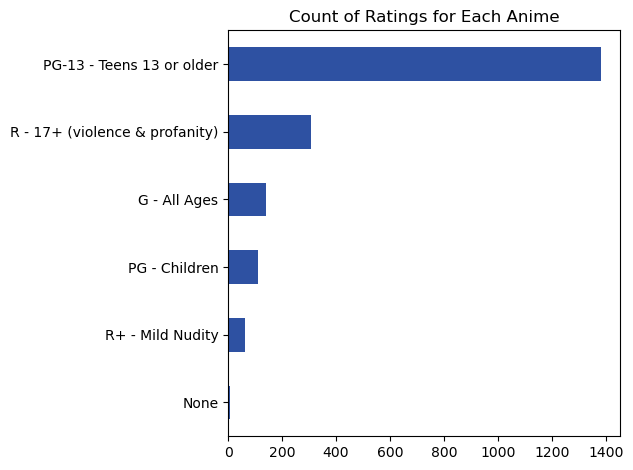

In [26]:
# Count the occurrences of each rating
rating_counts = df['Rating'].value_counts()
rating_counts = rating_counts.sort_values(ascending=True)

# Plotting the horizontal bar chart
rating_counts.plot(kind='barh', color='#2e51a2')
plt.title('Count of Ratings for Each Anime')
#plt.xlabel('Count')
#plt.ylabel('Rating')
plt.tight_layout()
plt.show()

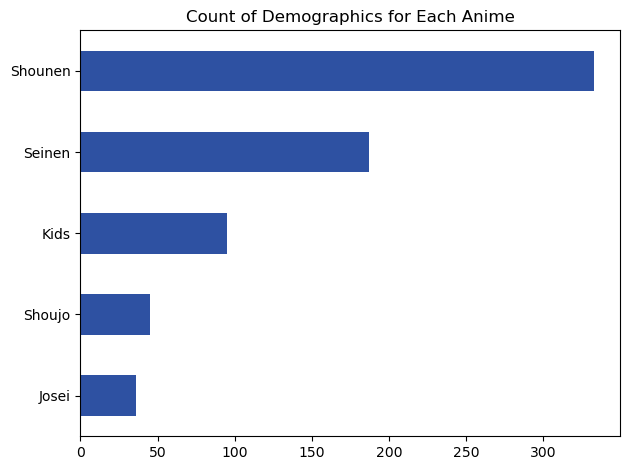

In [27]:
# Count the occurrences of each Demographic
demo_counts = df['Demographic'].value_counts()
demo_counts = demo_counts.sort_values(ascending=True)

# Plotting the horizontal bar chart
demo_counts.plot(kind='barh', color='#2e51a2')
plt.title('Count of Demographics for Each Anime')
#plt.xlabel('Count')
#plt.ylabel('Rating')
plt.tight_layout()
plt.show()

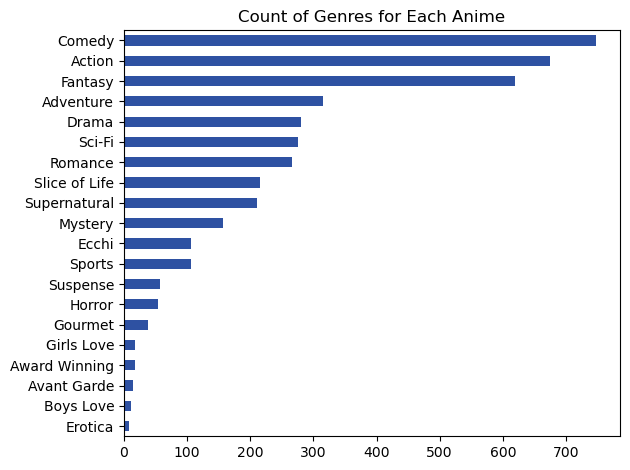

In [28]:
# Explode the 'Genres' column to separate rows for each genre
separated_genres = df.explode('Genres')

# Count the occurrences of each rating
genre_counts = separated_genres['Genres'].value_counts()
genre_counts = genre_counts.sort_values(ascending=True)

# Plotting the horizontal bar chart
genre_counts.plot(kind='barh', color='#2e51a2')
plt.title('Count of Genres for Each Anime')
#plt.xlabel('Count')
#plt.ylabel('Genre')
plt.tight_layout()

Text(0.5, 1.0, 'Count of Themes for Each Anime')

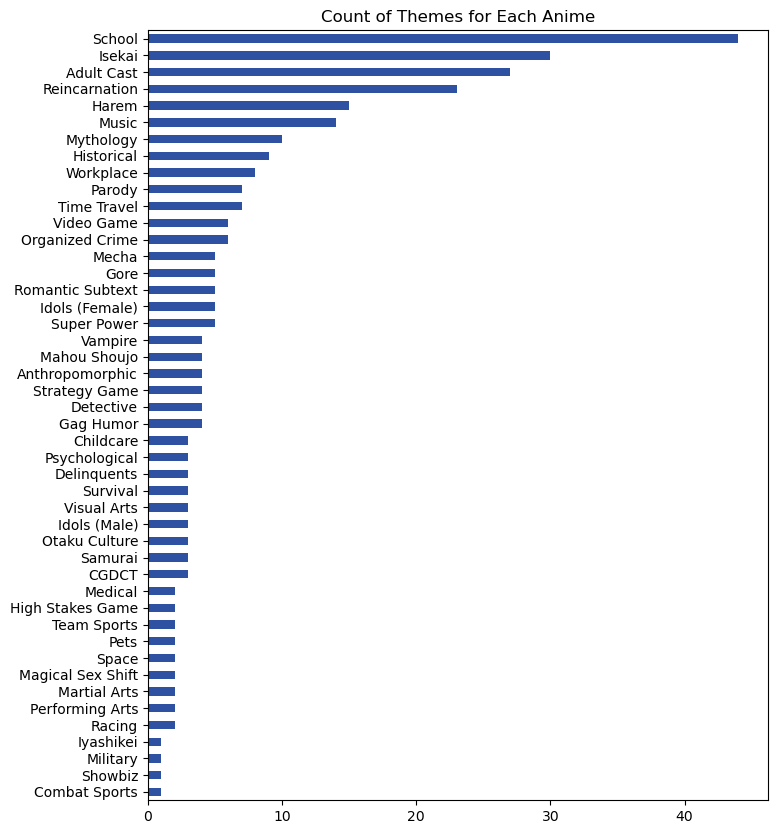

In [47]:
# Explode the 'Genres' column to separate rows for each genre
separated_themes = df.explode('Themes')

plt.figure(figsize=(8, 10))

# Count the occurrences of each rating
theme_counts = separated_themes['Themes'].value_counts()
theme_counts = theme_counts.sort_values(ascending=True)

# Plotting the horizontal bar chart
theme_counts.plot(kind='barh', color='#2e51a2')
plt.title('Count of Themes for Each Anime')
#plt.xlabel('Count')
#plt.ylabel('Genre')
#plt.tight_layout()

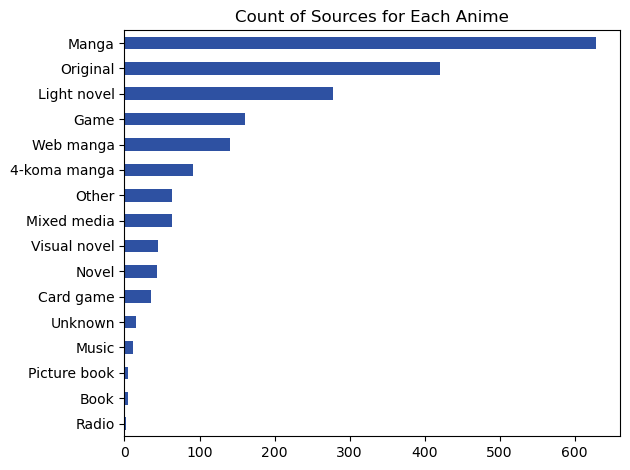

In [29]:
# Count the occurrences of each Demographic
source_counts = df['Source'].value_counts()
source_counts = source_counts.sort_values(ascending=True)

# Plotting the horizontal bar chart
source_counts.plot(kind='barh', color='#2e51a2')
plt.title('Count of Sources for Each Anime')
#plt.xlabel('Count')
#plt.ylabel('Rating')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Count of Studios for Each Anime')

/Users/luigibagos/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12539 (\N{KATAKANA MIDDLE DOT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


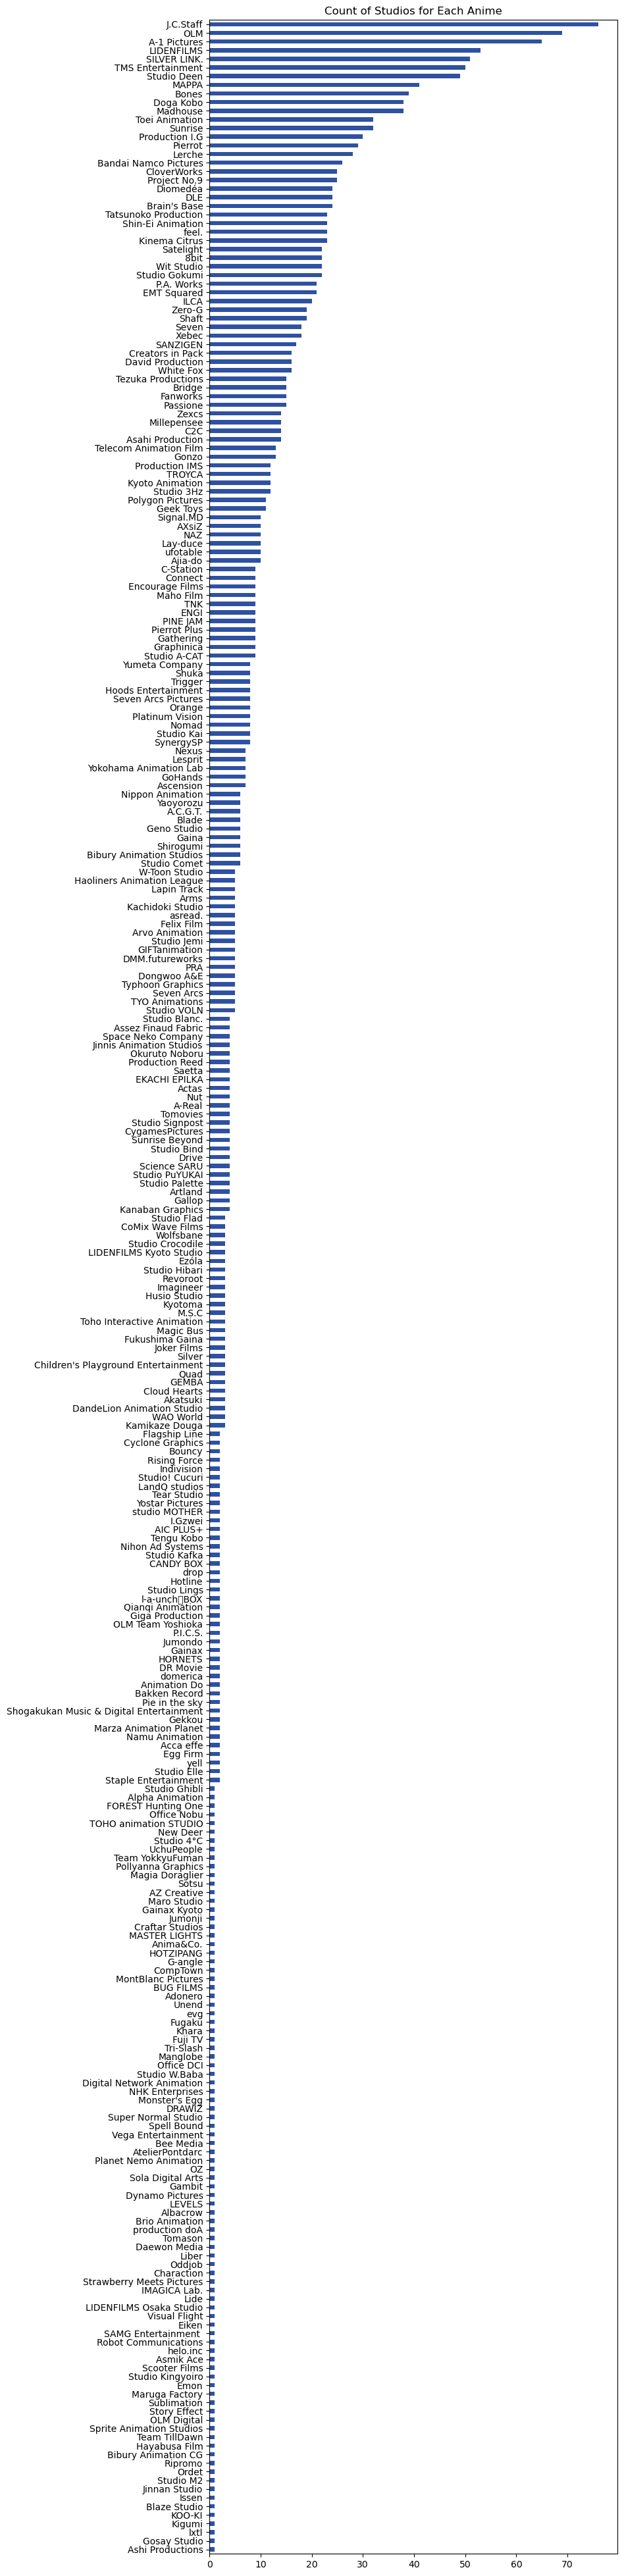

In [32]:
# Explode the 'Genres' column to separate rows for each genre
separated_studios = df.explode('Studios')

plt.figure(figsize=(8, 50))

# Count the occurrences of each rating
studio_counts = separated_studios['Studios'].value_counts()
studio_counts = studio_counts.sort_values(ascending=True)

# Plotting the horizontal bar chart
studio_counts.plot(kind='barh', color='#2e51a2')
plt.title('Count of Studios for Each Anime')
#plt.xlabel('Count')
#plt.ylabel('Genre')
#plt.tight_layout()

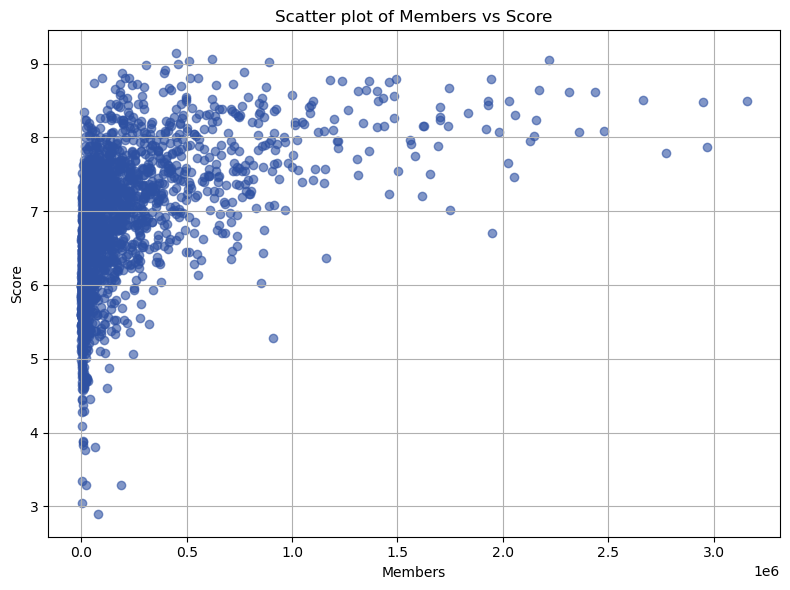

In [33]:
# Plotting a scatterplot for 'Members' vs 'Score'
plt.figure(figsize=(8, 6))  # Set the figure size if needed
plt.scatter(df['Members'], df['Score'], color='#2e51a2', alpha=0.6)  # Scatter plot
plt.title('Scatter plot of Members vs Score')
plt.xlabel('Members')
plt.ylabel('Score')
plt.grid(True)  # Show gridlines
plt.tight_layout()

plt.show()

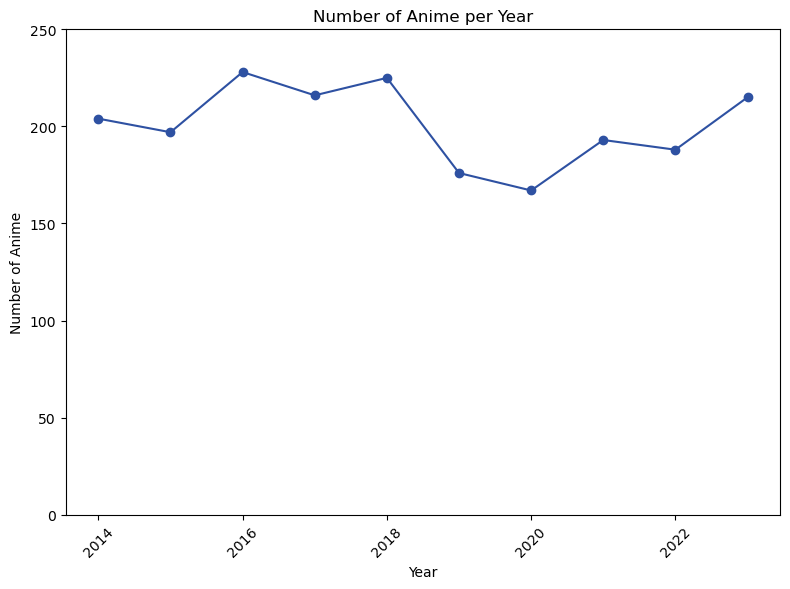

In [41]:
anime_per_year = df['Year'].value_counts().sort_index()

# Plotting the line chart
plt.figure(figsize=(8, 6))  # Set the figure size (width, height) in inches
plt.plot(anime_per_year.index, anime_per_year.values, marker='o', linestyle='-', color='#2e51a2')
plt.title('Number of Anime per Year')
plt.xlabel('Year')
plt.ylabel('Number of Anime')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.grid(False)  # Show gridlines
plt.ylim(0, 250)
plt.tight_layout()
plt.show()

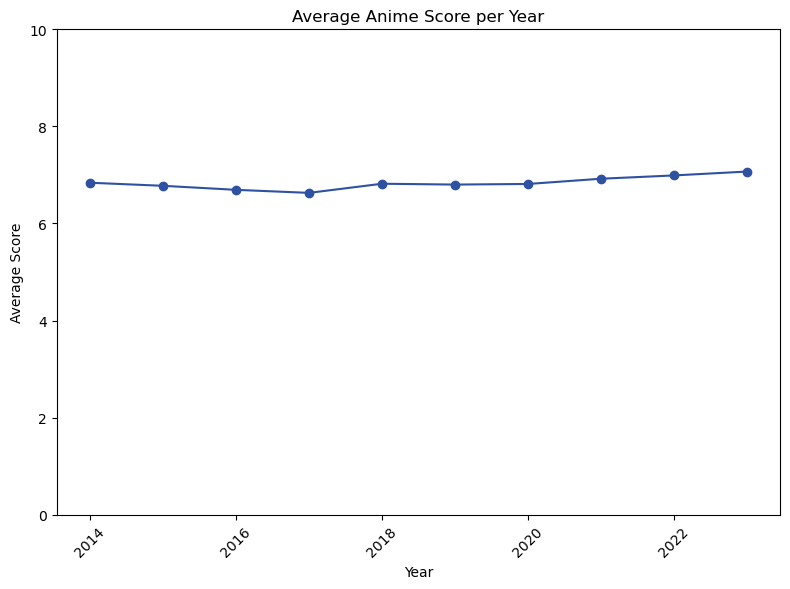

In [39]:
average_score_per_year = df.groupby('Year')['Score'].mean()

# Plotting the line chart
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.plot(average_score_per_year.index, average_score_per_year.values, marker='o', linestyle='-', color='#2e51a2')
plt.title('Average Anime Score per Year')
plt.xlabel('Year')
plt.ylabel('Average Score')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.grid(True)  # Show gridlines
plt.ylim(0, 10)  # Set the y-axis limits from 0 to 10
plt.tight_layout()
plt.grid(False)
plt.show()
